In [17]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

### Reading Data

 - **Date**: Date of the record 
 - **Open**: Opening price of the day 
 - **High**: Highest trade price during the day 
 - **Low**: Lowest trade price during the day
 - **Close**: The closing price for the day 
 - **Volume**: The number of shares traded
 - **Adj Close**: The daily closing price, adjusted retroactively to include any corporate actions (adjusted close)

In [18]:
#read the S&P Index Data

snphist = pd.read_csv('sphist.csv')
print(snphist.describe())
print("\ndf shape: ", snphist.shape)
snphist.head()

               Open          High           Low         Close        Volume  \
count  16590.000000  16590.000000  16590.000000  16590.000000  1.659000e+04   
mean     482.570941    485.624237    479.367501    482.692491  7.940099e+08   
std      554.889186    558.186049    551.367625    555.007904  1.456582e+09   
min       16.660000     16.660000     16.660000     16.660000  6.800000e+05   
25%       83.860001     84.594997     83.139997     83.860001  7.610000e+06   
50%      144.049996    145.294998    143.105004    144.264999  7.170500e+07   
75%      950.722488    956.665024    941.969986    950.797500  7.866750e+08   
max     2130.360107   2134.719971   2126.060059   2130.820068  1.145623e+10   

          Adj Close  
count  16590.000000  
mean     482.692491  
std      555.007904  
min       16.660000  
25%       83.860001  
50%      144.264999  
75%      950.797500  
max     2130.820068  

df shape:  (16590, 7)


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [19]:
# Convert 'Date' column to Pandas data type
snphist['Date'] = pd.to_datetime(snphist['Date'])

# Sort df by that column
snphist.sort_values(by=['Date'], inplace=True)
snphist.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


### New Indicators

In order to prevent injecting future knowledge into the moddel, we will create indicators based on the past:

1. Average price for the last 5 days
2. Average price for the last 365 days
3. Ratio between the average price for the past 5 days and the average price for the past 365 days
4. Standard deviation of the price for the last 5 days
5. Standard deviation of the price for the last 365 days
6. Ratio between the standard deviation for the past 5 days and the standard deviation for the past 365 days
7. The average volume for the past 5 days
8. The average volume for the past 365 days
9. The ratio between the average volume for the past 5 days and the average volume for the past 365 days
10. The ratio between the lowest price in the past year and the current price


In [20]:
# 1

snphist['avg_price_5'] = snphist['Close'].rolling(5).mean()
# Avoid using current day's price by reindexing
snphist['avg_price_5'] = snphist['avg_price_5'].shift()

# 2

snphist['avg_price_365'] = snphist['Close'].rolling(365).mean()
# Avoid using current day's price by reindexing
snphist['avg_price_365'] = snphist['avg_price_365'].shift()

# 3
snphist['avg_price_5_365'] = snphist['avg_price_5'] / snphist['avg_price_365']

# 4
snphist['std_price_5'] = snphist['Close'].rolling(5).std()
# Avoid using current day's price by reindexing
snphist['std_price_5'] = snphist['std_price_5'].shift() 

# 5 
snphist['std_price_365'] = snphist['Close'].rolling(365).std()
# Avoid using current day's price by reindexing
snphist['std_price_365'] = snphist['std_price_365'].shift() 

# 6
snphist['std_price_5_365'] = snphist['std_price_5'] / snphist['std_price_365']

# 7 
snphist['avg_volume_5'] = snphist['Volume'].rolling(5).mean()
# Avoid using current day's price by reindexing
snphist['avg_volume_5'] = snphist['avg_volume_5'].shift() 

# 8
snphist['avg_volume_365'] = snphist['Volume'].rolling(365).mean()
# Avoid using current day's price by reindexing
snphist['avg_volume_365'] = snphist['avg_volume_365'].shift() 

# 9
snphist['avg_volume_5_365'] = snphist['avg_volume_5'] / snphist['avg_volume_365']

# 10
min_last_year = snphist['Close'].rolling(365).min()
snphist['last_min_current_ratio'] = min_last_year / snphist['Close']
snphist['last_min_current_ratio'] = snphist['last_min_current_ratio'].shift()

### Data Cleaning

Since the new indicators now rely on previous 5 and 365 days, considering that the first observation corresponds to 1950-01-03, we need to 

1. Remove any rows from dataframe that is before 1951-01-03
2. Remove any rows with NaN values

In [21]:
print("# of observations before: ", snphist.shape[0])
print("NaN values before: \n\n", snphist.isnull().sum())

snphist = snphist[snphist['Date'] > datetime(year=1951, month=1, day=2)]
snphist.dropna(axis=0, inplace=True)

print("\n# of observations after: ", snphist.shape[0])
print("NaN values after: \n\n", snphist.isnull().sum())

# of observations before:  16590
NaN values before: 

 Date                        0
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
Adj Close                   0
avg_price_5                 5
avg_price_365             365
avg_price_5_365           365
std_price_5                 5
std_price_365             365
std_price_5_365           365
avg_volume_5                5
avg_volume_365            365
avg_volume_5_365          365
last_min_current_ratio    365
dtype: int64

# of observations after:  16225
NaN values after: 

 Date                      0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
Adj Close                 0
avg_price_5               0
avg_price_365             0
avg_price_5_365           0
std_price_5               0
std_price_365             0
std_price_5_365           0
avg_

### Train/Test Split

Train: Up to 2013-01-01 <br> <br>
Test: After 2013-01-01

In [22]:
train = snphist[snphist["Date"] < datetime(year=2013, month=1, day=1)]
test = snphist[snphist["Date"] >= datetime(year=2013, month=1, day=1)]

print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (15486, 17)
Test:  (739, 17)


### Linear Regression

last_min_current_ratio   -0.105400
avg_volume_5_365         -0.012305
avg_price_5_365           0.047782
std_price_5_365           0.087018
std_price_5               0.722414
Volume                    0.772817
avg_volume_5              0.780896
avg_volume_365            0.784878
std_price_365             0.816103
Date                      0.872202
avg_price_365             0.988870
avg_price_5               0.999793
Open                      0.999900
High                      0.999953
Low                       0.999956
Adj Close                 1.000000
Close                     1.000000
Name: Close, dtype: float64


<Axes: >

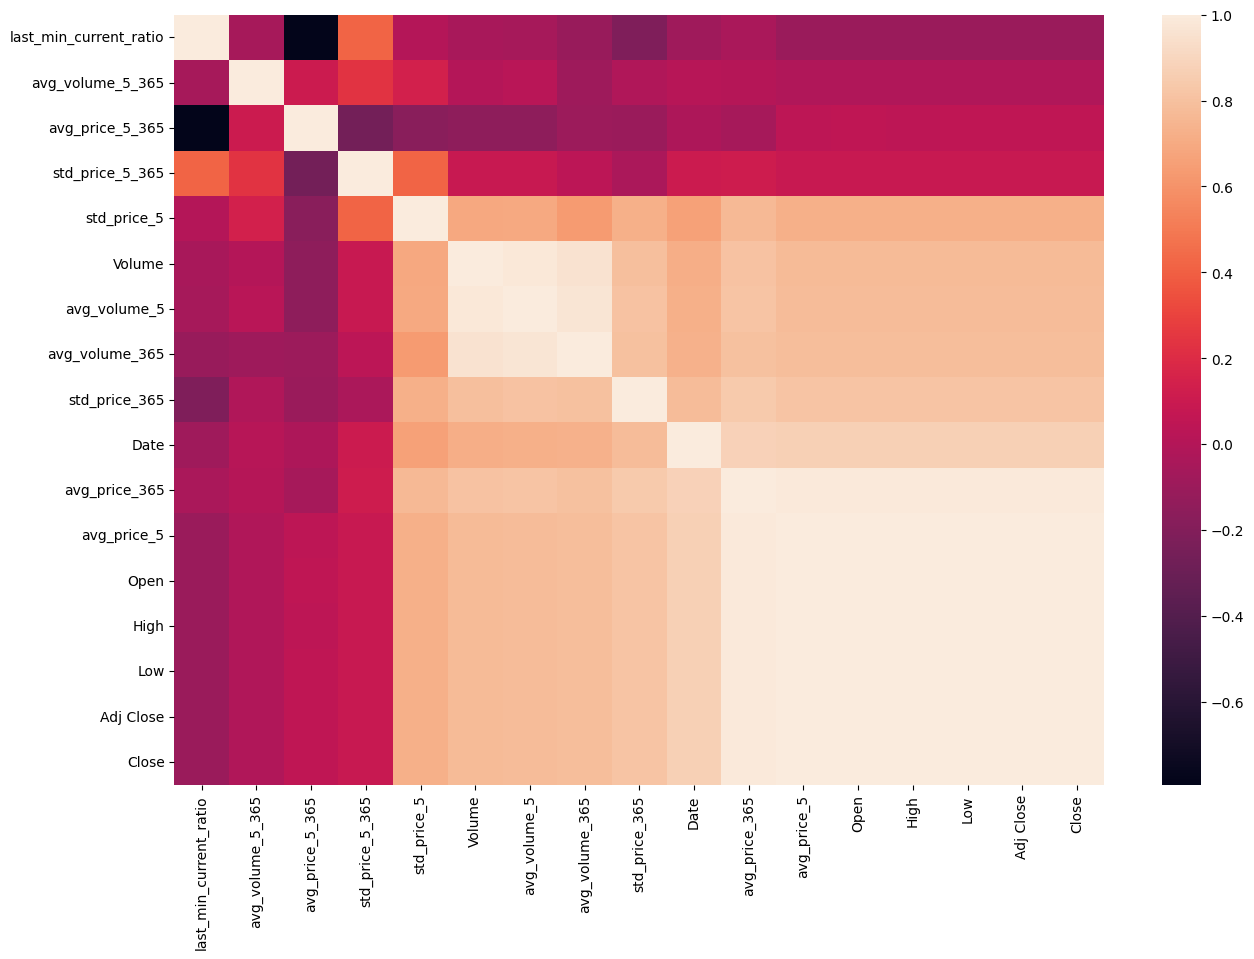

In [23]:
# Correlation Heatmap
sorted_corrs = snphist.corr()['Close'].sort_values()

print(sorted_corrs)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(snphist[sorted_corrs.index].corr())

In [24]:
features = ['avg_price_5', 'avg_price_365', 'avg_price_5_365', 'std_price_5', 
            'std_price_365', 'std_price_5_365', 'avg_volume_5', 'avg_volume_365', 
            'avg_volume_5_365', 'last_min_current_ratio']

X_train = train[features]
y_train = train['Close']

X_test = test[features]
y_test = test['Close']

# Train
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
closing_price_pred_lr = lr.predict(X_test)

# --------------------------------------------------
# Performance metrics
# --------------------------------------------------

# Calculate MSE
mse_lr = mean_squared_error(y_test, closing_price_pred_lr)

# Calculate the absolute errors and MAPE
errors_lr = abs(closing_price_pred_lr - y_test)
mape_lr = 100 * (errors_lr / y_test)

# MAE
mae_lr = round(np.mean(errors_lr), 2)

# Accuracy
accuracy_lr = 100 - np.mean(mape_lr)

print("-----------------\nLinear regression\n-----------------")
print("MSE: ", mse_lr)
print("MAE: ", mae_lr, "degrees")
print('Accuracy:', round(accuracy_lr, 2), '%.')

-----------------
Linear regression
-----------------
MSE:  485.0212370892355
MAE:  16.02 degrees
Accuracy: 99.15 %.


Linear Regression may have high accuracy but may not be as effective for predicting actual stock market behaviour as stock market dynamics often involve nonlinearities that linear regression cannot capture.

### Random Forest

In [25]:
rf = RandomForestRegressor(n_estimators=150, random_state=1, min_samples_leaf=2)

# Train 
rf.fit(X_train, y_train)

# Predict
closing_price_pred_rf = rf.predict(X_test)

# --------------------------------------------------
# Performance metrics
# --------------------------------------------------

# Calculate the absolute errors and MAPE
errors_rf = abs(closing_price_pred_rf - y_test)
mape_rf = 100 * (errors_rf / y_test)

# MAE
mae_rf = round(np.mean(errors_rf), 2)

# Accuracy
accuracy_rf = 100 - np.mean(mape_rf)

print("-----------------\nRandom Forest\n-----------------")
print("MAE: ", mae_rf, "degrees")
print('Accuracy:', round(accuracy_rf, 2), '%.')

-----------------
Random Forest
-----------------
MAE:  345.83 degrees
Accuracy: 82.47 %.
